<a href="https://colab.research.google.com/github/MedhatHassan/MedhatHassan/blob/main/MD5_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
# from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [3]:
dataset = pd.read_csv('/content/md5_data.csv')

In [4]:
dataset = array(dataset)

In [5]:
for i in range(len(dataset)):
    dataset[i,0] = dataset[i,0].lower()
    dataset[i,1] = dataset[i,1].lower()

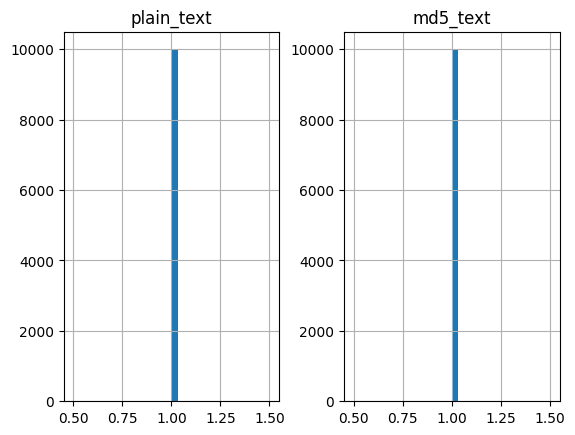

In [6]:
plain_text = []
md5_text = []

# populate the lists with sentence lengths
for i in dataset[:,0]:
      plain_text.append(len(i.split()))

for i in dataset[:,1]:
      md5_text.append(len(i.split()))

length_df = pd.DataFrame({'plain_text':plain_text, 'md5_text':md5_text})

length_df.hist(bins = 30)
plt.show()

In [7]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [8]:
plain_text_tokenizer = tokenization(dataset[:, 0])
plain_text_size = len(plain_text_tokenizer.word_index) + 1

plain_text_length = 1
print('plain text Size: %d' % plain_text_size)

plain text Size: 10000


In [9]:
md5_text_tokenizer = tokenization(dataset[:, 1])
md5_text_size = len(md5_text_tokenizer.word_index) + 1

md5_text_length = 1
print('md5 text Size: %d' % md5_text_size)

md5 text Size: 10000


In [10]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [11]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(dataset, test_size=0.2, random_state = 12)

In [12]:
trainX = encode_sequences(md5_text_tokenizer, md5_text_length, train[:, 1])
trainY = encode_sequences(plain_text_tokenizer, plain_text_length, train[:, 0])

testX = encode_sequences(md5_text_tokenizer, md5_text_length, test[:, 1])
testY = encode_sequences(plain_text_tokenizer, plain_text_length, test[:, 0])

In [13]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [14]:
model = define_model(md5_text_size, plain_text_size, md5_text_length, plain_text_length, 128)

In [15]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [29]:
filename = 'model.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 9.2132
Epoch 1: val_loss improved from inf to 9.21787, saving model to model.h1


13/13 [==============================] - 40s 3s/step - loss: 9.2132 - val_loss: 9.2179
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 9.2042
Epoch 2: val_loss did not improve from 9.21787
13/13 [==============================] - 13s 969ms/step - loss: 9.2042 - val_loss: 9.2296
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 9.1875
Epoch 3: val_loss did not improve from 9.21787
13/13 [==============================] - 12s 957ms/step - loss: 9.1875 - val_loss: 9.3468
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 9.0932
Epoch 4: val_loss did not improve from 9.21787
13/13 [==============================] - 12s 934ms/step - loss: 9.0932 - val_loss: 9.7055
Epoch 5/30
13/13 [==============================] - ETA: 0s - loss: 8.9234
Epoch 5: val_loss did not improve from 9.21787
13/13 [==============================] - 12s 961ms/step - loss: 8.9234 - val_loss: 9.9487
Epoch 6/30
13/13 [==============================] - ETA: 0s - los

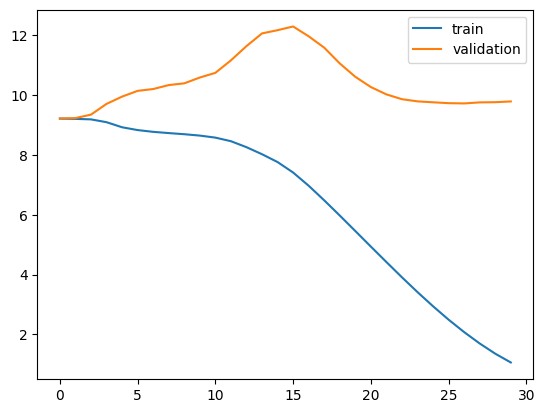

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [33]:
model = load_model('model.h1')
preds = model.predict(trainX[10])
preds

1/1 [==============================] - 2s 2s/step


array([[[9.93311478e-05, 1.00200545e-04, 9.92413989e-05, ...,
         9.92167479e-05, 1.00626930e-04, 1.00286270e-04]]], dtype=float32)